<a href="https://colab.research.google.com/github/nilesh3030/Stroke-Prediction/blob/main/Notebooks/5_modelling_Random_Search_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option ('display.max_columns', None)
pd.set_option ('display.max_rows', None)

In [2]:
## Data splitting and scaling
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, f1_score
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# !pip install mlflow
# import mlflow
# import mlflow.sklearn

In [4]:
model_data = pd.read_csv('/content/drive/MyDrive/Stroke_Prediction/Data/Modelling Data/model_data_2021_2022_with_weather_vars.csv')

In [5]:
model_data.columns

Index(['Unnamed: 0', 'cv_cc', 'cv2_cc', 'cv2_act', 'sex', 'stroke',
       'cv2_cphss', 'triage', 'onset', 'jaenan_sn', 'age', 'dbp1', 'sbp1',
       'pr1', 'rr1', 'bt1', 'spo2_1', 'dbp2', 'sbp2', 'pr2', 'rr2', 'bt2',
       'spo2_2', 'Spasm', 'Dizziness', 'Faint', 'Consciousness', 'Paralysis',
       'hy_di_disease', 'Disease_counts', 'Branch_name', 'Temperature',
       'Wind_Speed(m/s)', 'Precipitation(mm)', 'Humidity(%)', 'Temp_max_month',
       'Temp_min_month', 'Temp_avg_month', 'Humidity_max_month',
       'Humidity_min_month', 'Humidity_avg_month', 'diff_Temp_max_month',
       'diff_Temp_min_month', 'diff_Temp_avg_month', 'diff_Humidity_max_month',
       'diff_Humidity_min_month', 'diff_Humidity_avg_month', 'Temp_max_day',
       'Temp_min_day', 'Temp_avg_day', 'Humidity_max_day', 'Humidity_min_day',
       'Humidity_avg_day', 'diff_Temp_max_day', 'diff_Temp_min_day',
       'diff_Temp_avg_day', 'diff_Humidity_max_day', 'diff_Humidity_min_day',
       'diff_Humidity_avg_day'

In [6]:
model_data.shape

(99723, 59)

In [7]:
### We won't need alll the variables to run our model so dropping the unwanted vars
vars_to_drop = ['Unnamed: 0', 'jaenan_sn', 'Branch_name', 'dbp2', 'sbp2', 'pr2', 'rr2',
       'bt2', 'spo2_2', 'Wind_Speed(m/s)', 'Precipitation(mm)', 'Humidity(%)', 'Humidity_max_month', 'Humidity_min_month', 'Humidity_avg_month',
       'diff_Temp_max_month', 'diff_Temp_min_month', 'diff_Temp_avg_month',
       'diff_Humidity_max_month', 'diff_Humidity_min_month',
       'diff_Humidity_avg_month', 'Temp_max_day', 'Temp_min_day',
       'Temp_avg_day', 'Humidity_max_day', 'Humidity_min_day',
       'Humidity_avg_day','diff_Humidity_max_day', 'diff_Humidity_min_day',
       'diff_Humidity_avg_day']

model_data = model_data.drop(vars_to_drop, axis = 1)
model_data.shape

(99723, 29)

In [8]:
null_variables = round((model_data.isna().sum()/len(model_data))*100,2)
null_variables

cv_cc                3.14
cv2_cc               3.87
cv2_act              0.01
sex                  0.00
stroke               0.00
cv2_cphss            0.01
triage               0.03
onset                0.00
age                  0.01
dbp1                 3.53
sbp1                 2.13
pr1                  0.43
rr1                  0.41
bt1                  0.53
spo2_1               1.11
Spasm                0.00
Dizziness            0.00
Faint                0.00
Consciousness        0.00
Paralysis            0.00
hy_di_disease        0.00
Disease_counts       0.00
Temperature          2.13
Temp_max_month       1.93
Temp_min_month       1.93
Temp_avg_month       1.93
diff_Temp_max_day    2.16
diff_Temp_min_day    2.16
diff_Temp_avg_day    2.16
dtype: float64

In [9]:
model_data = model_data.dropna()
model_data.shape

(89520, 29)

In [10]:
model_data.cv2_cphss.value_counts()

1.0    51341
0.0    38179
Name: cv2_cphss, dtype: int64

In [11]:
model_data.head()

,cv_cc,cv2_cc,cv2_act,sex,stroke,cv2_cphss,triage,onset,age,dbp1,sbp1,pr1,rr1,bt1,spo2_1,Spasm,Dizziness,Faint,Consciousness,Paralysis,hy_di_disease,Disease_counts,Temperature,Temp_max_month,Temp_min_month,Temp_avg_month,diff_Temp_max_day,diff_Temp_min_day,diff_Temp_avg_day
0,Cerebralgia,Consciousness,Everyday life,0,0,1.0,Emergency symptoms,0,76.0,81.0,117.0,149.0,14.0,37.1,96.0,0,0,0,1,0,0,0,9.2,11.0,-19.9,-3.444953,3.8,0.3,1.737500
1,Cerebralgia,Consciousness,Everyday life,0,0,1.0,Emergency symptoms,0,78.0,70.0,120.0,144.0,28.0,40.0,92.0,0,0,0,1,0,1,3,-2.6,16.6,-12.2,-0.290199,-0.8,1.2,0.454167
2,Cerebralgia,Upper body Paralysis,on duty,0,0,1.0,Emergency symptoms,0,50.0,118.0,227.0,101.0,15.0,37.7,98.0,0,0,0,0,1,1,1,-1.9,16.2,-9.7,0.387443,-7.0,-3.0,-6.058333
3,"Heart, cerebrovascular",Faint,Everyday life,1,0,0.0,Quasi -negative,0,74.0,100.0,180.0,111.0,18.0,36.3,99.0,0,0,1,0,0,1,2,3.3,16.6,-12.2,-0.290199,-6.5,-13.9,-8.762500
4,Cerebralgia,Upper body Paralysis,After sleep,1,0,1.0,Emergency symptoms,0,28.0,110.0,220.0,96.0,13.0,37.2,98.0,0,0,0,0,1,1,1,2.6,18.6,-10.0,0.733206,-6.8,-7.7,-5.762500


In [12]:
## Creating a copy of model data for LR model
model_data_LR = model_data.copy()

In [16]:
## Creating the one hot encoding for categorical varrs
feature_to_encode = ['cv_cc', 'cv2_cc', 'cv2_act', 'triage']

dummies = pd.get_dummies(model_data_LR[feature_to_encode])
LR_data = pd.concat([model_data_LR, dummies], axis=1)
LR_data = LR_data.drop(feature_to_encode, axis=1)

In [16]:
LR_data.head()

,sex,stroke,cv2_cphss,onset,age,dbp1,sbp1,pr1,rr1,bt1,spo2_1,Spasm,Dizziness,Faint,Consciousness,Paralysis,hy_di_disease,Disease_counts,Temperature,Temp_max_month,Temp_min_month,Temp_avg_month,diff_Temp_max_day,diff_Temp_min_day,diff_Temp_avg_day,cv_cc_Cerebralgia,"cv_cc_Heart, cerebrovascular",cv2_cc_Consciousness,cv2_cc_Faint,cv2_cc_Leg Paralysis,cv2_cc_Leg Planting/paralysis (left),cv2_cc_Misc,cv2_cc_Normal Symptoms,cv2_cc_Upper body Paralysis,cv2_cc_strange pronunciation,cv2_act_After sleep,cv2_act_During treatment,cv2_act_Everyday life,cv2_act_Sports/leisure,cv2_act_Unclear,cv2_act_on duty,triage_Emergency symptoms,triage_Potential emergency symptom,triage_Quasi,triage_Quasi -negative
0,0,0,1.0,0,76.0,81.0,117.0,149.0,14.0,37.1,96.0,0,0,0,1,0,0,0,9.2,11.0,-19.9,-3.444953,3.8,0.3,1.737500,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,0,0,1.0,0,78.0,70.0,120.0,144.0,28.0,40.0,92.0,0,0,0,1,0,1,3,-2.6,16.6,-12.2,-0.290199,-0.8,1.2,0.454167,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,0,0,1.0,0,50.0,118.0,227.0,101.0,15.0,37.7,98.0,0,0,0,0,1,1,1,-1.9,16.2,-9.7,0.387443,-7.0,-3.0,-6.058333,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0
3,1,0,0.0,0,74.0,100.0,180.0,111.0,18.0,36.3,99.0,0,0,1,0,0,1,2,3.3,16.6,-12.2,-0.290199,-6.5,-13.9,-8.762500,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,1,0,1.0,0,28.0,110.0,220.0,96.0,13.0,37.2,98.0,0,0,0,0,1,1,1,2.6,18.6,-10.0,0.733206,-6.8,-7.7,-5.762500,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0


In [17]:
vars_to_scale = ['age', 'dbp1','sbp1','pr1','rr1','bt1','spo2_1','Temperature','Temp_max_month','Temp_min_month','Temp_avg_month','diff_Temp_max_day','diff_Temp_min_day','diff_Temp_avg_day']
scaler = StandardScaler()
LR_data[vars_to_scale] = scaler.fit_transform(LR_data[vars_to_scale])
LR_data.head()

,sex,stroke,cv2_cphss,onset,age,dbp1,sbp1,pr1,rr1,bt1,spo2_1,Spasm,Dizziness,Faint,Consciousness,Paralysis,hy_di_disease,Disease_counts,Temperature,Temp_max_month,Temp_min_month,Temp_avg_month,diff_Temp_max_day,diff_Temp_min_day,diff_Temp_avg_day
0,0,0,1.0,0,0.541588,-0.046932,-0.519526,3.015933,-0.942263,0.288808,0.116745,0,0,0,1,0,0,0,-0.506693,-2.025688,-1.875167,-1.807975,1.097934,0.094109,0.691370
1,0,0,1.0,0,0.648558,-0.568320,-0.431242,2.776777,2.428634,3.186554,-0.388068,0,0,0,1,0,1,3,-1.644439,-1.262187,-1.223975,-1.471471,-0.250367,0.411661,0.167923
2,0,0,1.0,0,-0.849025,1.706828,2.717543,0.720035,-0.701485,0.888342,0.369151,0,0,0,0,1,1,1,-1.576946,-1.316723,-1.012549,-1.399190,-2.067643,-1.070249,-2.488402
3,1,0,0.0,0,0.434618,0.853648,1.334432,1.198347,0.020850,-0.510570,0.495355,0,0,1,0,0,1,2,-1.075566,-1.262187,-1.223975,-1.471471,-1.921088,-4.916159,-3.591380
4,1,0,1.0,0,-2.025698,1.327637,2.511548,0.480879,-1.183042,0.388730,0.369151,0,0,0,0,1,1,1,-1.143060,-0.989508,-1.037920,-1.362309,-2.009021,-2.728577,-2.367737


In [18]:
X = LR_data.iloc[:,LR_data.columns != 'cv2_cphss']
y = LR_data.cv2_cphss
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5, stratify=y)

In [19]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# apply near miss
from imblearn.under_sampling import NearMiss
nr = NearMiss()

X_train_miss, y_train_miss = nr.fit_resample(X_train, y_train.ravel())

print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape))
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape))

print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1)))
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0)))

Before Undersampling, counts of label '1': 41073
Before Undersampling, counts of label '0': 30543 

After Undersampling, the shape of train_X: (61086, 44)
After Undersampling, the shape of train_y: (61086,) 

After Undersampling, counts of label '1': 30543
After Undersampling, counts of label '0': 30543


In [20]:
model = LogisticRegression()
model.fit(X_train_miss, y_train_miss)
y_pred = model.predict(X_test)

# metrics are used to find accuracy or error
train_acc = model.score(X_train_miss, y_train_miss)
print("The Accuracy for Training Set is {}".format(train_acc*100))

test_acc = accuracy_score(y_test, y_pred)
print("The Accuracy for Test Set is {}".format(test_acc*100))

print(classification_report(y_test, y_pred))

The Accuracy for Training Set is 82.7489113708542
The Accuracy for Test Set is 83.32216264521894
              precision    recall  f1-score   support

         0.0       0.84      0.75      0.79      7636
         1.0       0.83      0.89      0.86     10268

    accuracy                           0.83     17904
   macro avg       0.83      0.82      0.83     17904
weighted avg       0.83      0.83      0.83     17904



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
n_estimators_range = np.arange(100, 500, 25)
max_depth_range = np.arange(5, 25, 2)
max_features_range = ["sqrt", None, "log2"]

param_grid = {
    "n_estimators": n_estimators_range,
    "max_depth": max_depth_range,
    "max_features": max_features_range,
}

rf_model = RandomForestClassifier(class_weight='balanced', n_jobs=-1)  # Create the base model

# Use RandomizedSearchCV with 5-fold cross-validation and 20 iterations
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, cv=5, n_iter=20)

rf_random.fit(X_train, y_train)  # Fit the model with hyperparameter tuning

# Get the best model with optimal hyperparameters
best_model = rf_random.best_estimator_

y_pred = best_model.predict(X_test)  # Make predictions on the test set

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Print or store the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC:", auc)
print(classification_report(y_test, y_pred))

Accuracy: 0.8522676496872207
Precision: 0.8262432594367884
Recall: 0.9401051811453058
F1-score: 0.8795043505990615
AUC: 0.8371295942394942
              precision    recall  f1-score   support

         0.0       0.90      0.73      0.81      7636
         1.0       0.83      0.94      0.88     10268

    accuracy                           0.85     17904
   macro avg       0.86      0.84      0.84     17904
weighted avg       0.86      0.85      0.85     17904



In [46]:
rf_random.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=17, n_estimators=400,
                       n_jobs=-1)

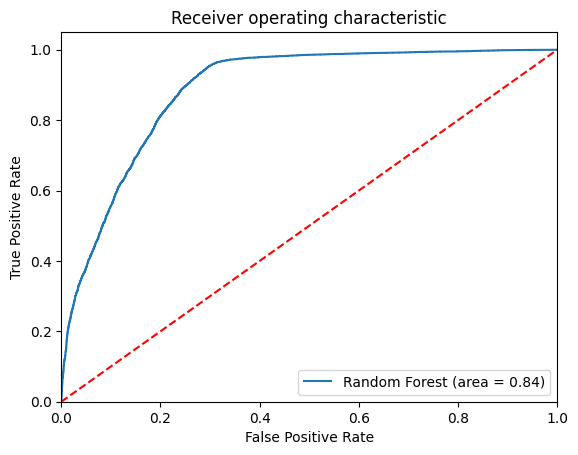

In [21]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [22]:
feature_imp = pd.Series(best_model.feature_importances_, index = X_train.columns).sort_values(ascending = False)
feature_imp

Dizziness                               0.077413
cv2_cc_Faint                            0.075151
cv2_cc_Normal Symptoms                  0.070421
Faint                                   0.067748
Consciousness                           0.062925
Paralysis                               0.061300
triage_Emergency symptoms               0.057533
cv2_cc_Consciousness                    0.038810
cv2_cc_Upper body Paralysis             0.038268
cv_cc_Heart, cerebrovascular            0.038198
cv_cc_Cerebralgia                       0.031313
age                                     0.030871
cv2_cc_strange pronunciation            0.028989
spo2_1                                  0.024596
sbp1                                    0.019943
bt1                                     0.019894
pr1                                     0.019529
diff_Temp_avg_day                       0.018801
Temperature                             0.018221
Temp_avg_month                          0.017833
diff_Temp_max_day   

In [ ]:
objective = 'binary'
boosting_type_range = ['gbdt', 'dart', 'goss']
max_depth_range = np.arange(1, 20, 2)
learning_rate_range = np.arange(0.001, 0.01, 0.001)

param_grid = {
    "boosting_type": boosting_type_range,
    "max_depth": max_depth_range,
    "learning_rate": learning_rate_range,
}

lgb_model = lgb.LGBMClassifier(objective=objective, num_leaves=31)  # Set base model objective

# Use RandomizedSearchCV with 5-fold cross-validation and 20 iterations
lgb_random = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_grid, cv=5, n_iter=20)

lgb_random.fit(X_train, y_train)  # Fit the model with hyperparameter tuning

# Get the best model with optimal hyperparameters
best_model = lgb_random.best_estimator_

y_pred = best_model.predict(X_test)  # Make predictions on the test set

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Print or store the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC:", auc)
print(classification_report(y_test, y_pred))

In [ ]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Light GBM (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [42]:
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weight = class_weights[1]/class_weights[0]
booster_type_range = ['gbtree', 'gblinear', 'dart']
max_depth_range = np.arange(1, 25, 2)
max_leaves = 0

param_grid = {
    "booster": booster_type_range,
    "max_depth": max_depth_range,
}

# Create base XGBoost classifier with class weights
xgb_model = XGBClassifier(scale_pos_weight = class_weight)

# Use RandomizedSearchCV with 5-fold cross-validation and 20 iterations
xgb_random = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, cv=5, n_iter=20)

xgb_random.fit(X_train, y_train)  # Fit the model with hyperparameter tuning

# Get the best model with optimal hyperparameters
best_model = xgb_random.best_estimator_

y_pred = best_model.predict(X_test)  # Make predictions on the test set

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Print or store the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC:", auc)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:58:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:58:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:58:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:58:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:58:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn

Accuracy: 0.8473525469168901
Precision: 0.8369555495930596
Recall: 0.911375146084924
F1-score: 0.8725814723297124
AUC: 0.8363187935767732
              precision    recall  f1-score   support

         0.0       0.86      0.76      0.81      7636
         1.0       0.84      0.91      0.87     10268

    accuracy                           0.85     17904
   macro avg       0.85      0.84      0.84     17904
weighted avg       0.85      0.85      0.85     17904



In [45]:
xgb_random.best_estimator_

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

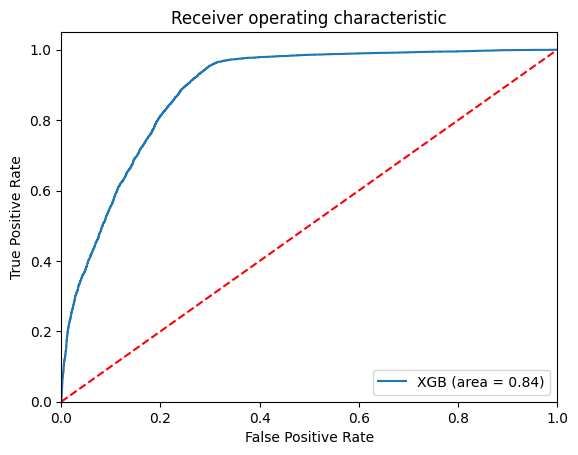

In [43]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGB (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [44]:
feature_imp = pd.Series(best_model.feature_importances_, index = X_train.columns).sort_values(ascending = False)
feature_imp

cv2_cc_Normal Symptoms                  0.380812
Faint                                   0.223205
cv2_cc_Faint                            0.189600
cv2_cc_Misc                             0.047945
Dizziness                               0.021156
triage_Emergency symptoms               0.019578
Paralysis                               0.017324
cv2_cc_strange pronunciation            0.013802
Consciousness                           0.010624
cv2_cc_Upper body Paralysis             0.009185
cv2_cc_Leg Paralysis                    0.008814
cv2_cc_Consciousness                    0.008187
triage_Potential emergency symptom      0.007519
hy_di_disease                           0.004464
stroke                                  0.003334
cv_cc_Cerebralgia                       0.002711
spo2_1                                  0.002500
cv2_cc_Leg Planting/paralysis (left)    0.001708
age                                     0.001699
cv2_act_After sleep                     0.001642
sbp1                

#Creating tree models Label feature encodings

In [13]:
# Create a label encoder
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
feature_to_encode = ['cv_cc', 'cv2_cc', 'cv2_act', 'triage']
# Encode the specified features
for feature in feature_to_encode:
    model_data[feature] = encoder.fit_transform(model_data[feature])

In [14]:
X_2 = model_data.iloc[:,model_data.columns != 'cv2_cphss']
y_2 = model_data.cv2_cphss
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.20, random_state=5)

In [15]:
n_estimators_range = np.arange(100, 500, 25)
max_depth_range = np.arange(5, 25, 2)
max_features_range = ["sqrt", None, "log2"]

param_grid = {
    "n_estimators": n_estimators_range,
    "max_depth": max_depth_range,
    "max_features": max_features_range,
}

rf_model = RandomForestClassifier(class_weight='balanced', n_jobs=-1)  # Create the base model

# Use RandomizedSearchCV with 5-fold cross-validation and 20 iterations
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, cv=5, n_iter=20)

rf_random.fit(X_train_2, y_train_2)  # Fit the model with hyperparameter tuning

# Get the best model with optimal hyperparameters
best_model_rf_2 = rf_random.best_estimator_

y_pred = best_model_rf_2.predict(X_test_2)  # Make predictions on the test set

accuracy = accuracy_score(y_test_2, y_pred)
precision = precision_score(y_test_2, y_pred)
recall = recall_score(y_test_2, y_pred)
f1 = f1_score(y_test_2, y_pred)
auc = roc_auc_score(y_test_2, y_pred)

# Print or store the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC:", auc)
print(classification_report(y_test_2, y_pred))

Accuracy: 0.8490840035746202
Precision: 0.8219899809984453
Recall: 0.9368970269738137
F1-score: 0.87569009937431
AUC: 0.8354121075999975
              precision    recall  f1-score   support

         0.0       0.90      0.73      0.81      7746
         1.0       0.82      0.94      0.88     10158

    accuracy                           0.85     17904
   macro avg       0.86      0.84      0.84     17904
weighted avg       0.86      0.85      0.85     17904



In [16]:
feature_imp = pd.Series(best_model_rf_2.feature_importances_, index = X_train_2.columns).sort_values(ascending = False)
feature_imp

cv2_cc               0.184532
Faint                0.135902
Dizziness            0.106799
Consciousness        0.105298
Paralysis            0.097932
triage               0.091589
cv_cc                0.049325
age                  0.030894
spo2_1               0.025942
sbp1                 0.016735
bt1                  0.014609
pr1                  0.013280
dbp1                 0.012068
Temperature          0.011555
diff_Temp_avg_day    0.011460
Temp_avg_month       0.011074
diff_Temp_max_day    0.010807
diff_Temp_min_day    0.010641
Temp_max_month       0.010499
Temp_min_month       0.010415
rr1                  0.009510
cv2_act              0.005626
Spasm                0.005158
Disease_counts       0.005007
stroke               0.004724
hy_di_disease        0.004104
sex                  0.002532
onset                0.001982
dtype: float64

In [17]:
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train_2)
class_weight = class_weights[1]/class_weights[0]
booster_type_range = ['gbtree', 'gblinear', 'dart']
max_depth_range = np.arange(1, 25, 2)
max_leaves = 0

param_grid = {
    "booster": booster_type_range,
    "max_depth": max_depth_range,
}

# Create base XGBoost classifier with class weights
xgb_model = XGBClassifier(scale_pos_weight = class_weight)

# Use RandomizedSearchCV with 5-fold cross-validation and 20 iterations
xgb_random = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, cv=5, n_iter=20)

xgb_random.fit(X_train_2, y_train_2)  # Fit the model with hyperparameter tuning

# Get the best model with optimal hyperparameters
best_model_XGB_2 = xgb_random.best_estimator_

y_pred = best_model_XGB_2.predict(X_test_2)  # Make predictions on the test set

accuracy = accuracy_score(y_test_2, y_pred)
precision = precision_score(y_test_2, y_pred)
recall = recall_score(y_test_2, y_pred)
f1 = f1_score(y_test_2, y_pred)
auc = roc_auc_score(y_test_2, y_pred)

# Print or store the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC:", auc)
print(classification_report(y_test_2, y_pred))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:40:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:40:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:40:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:40:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:40:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn

Accuracy: 0.8471291331546024
Precision: 0.8340686053839921
Recall: 0.9119905493207324
F1-score: 0.8712908535151658
AUC: 0.8370306477561575
              precision    recall  f1-score   support

         0.0       0.87      0.76      0.81      7746
         1.0       0.83      0.91      0.87     10158

    accuracy                           0.85     17904
   macro avg       0.85      0.84      0.84     17904
weighted avg       0.85      0.85      0.85     17904



In [18]:
feature_imp = pd.Series(best_model_XGB_2.feature_importances_, index = X_train_2.columns).sort_values(ascending = False)
feature_imp

Faint                0.384695
Dizziness            0.270367
cv2_cc               0.075614
triage               0.072274
Consciousness        0.069838
Paralysis            0.044083
hy_di_disease        0.014568
stroke               0.010677
spo2_1               0.009317
age                  0.006122
cv_cc                0.004106
onset                0.004065
dbp1                 0.003835
Spasm                0.003476
bt1                  0.003274
sbp1                 0.003222
cv2_act              0.002588
Disease_counts       0.002184
sex                  0.002145
Temp_min_month       0.001940
Temperature          0.001681
pr1                  0.001675
rr1                  0.001659
Temp_avg_month       0.001491
diff_Temp_max_day    0.001403
Temp_max_month       0.001325
diff_Temp_avg_day    0.001197
diff_Temp_min_day    0.001179
dtype: float32